In [1]:
from models.MNIST_Models import *
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import utils
from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool
from art.defences.trainer import AdversarialTrainer
from copy import deepcopy

In [2]:
# Load the data
BATCH_SIZE = 256

torch.manual_seed(42)
np.random.seed(42)
generator = torch.Generator().manual_seed(42)

# Define the transformation
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transform, download=True)

# Split the training dataset into training and validation datasets
train_dataset, val_dataset = random_split(train_dataset, [50000, 10000], generator=generator)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

X_train, y_train = utils.loader_to_numpy(train_loader)
X_val, y_val = utils.loader_to_numpy(val_loader)
X_test, y_test = utils.loader_to_numpy(test_loader)

Clean accuracy: 0.9845
Accuracy on adversarial test data:  0.3286


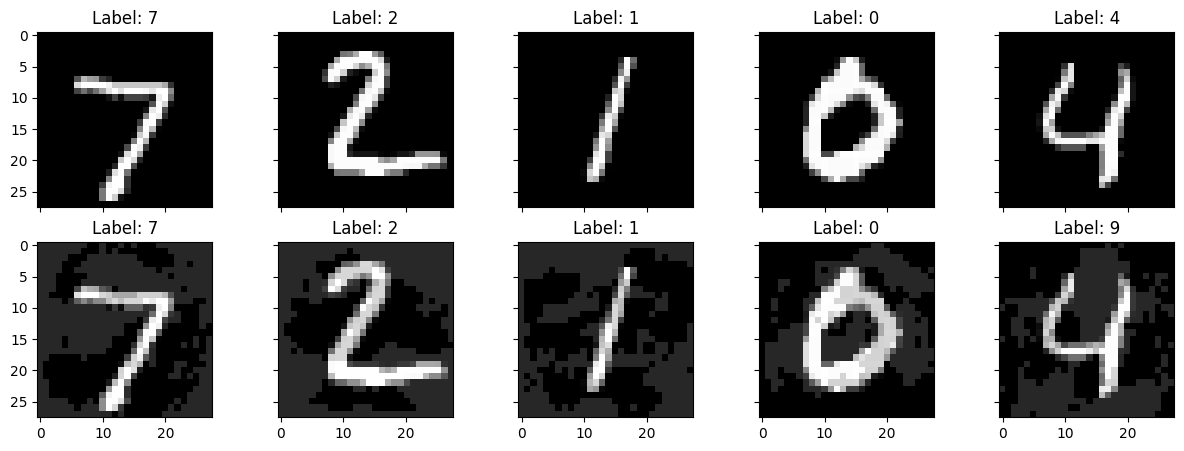

In [3]:
BATCH_SIZE = 1000

# load the FC model
clean_model = MNIST_FC_500_100_10()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_FC_500_100_10.pth'))
clean_model.eval()
clean_classifier = PyTorchClassifier(
    model=clean_model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(clean_model.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

# Get the clean accuracy
clean_acc = np.sum(np.argmax(clean_classifier.predict(X_test), axis=1) == y_test) / len(y_test)
print(f'Clean accuracy: {clean_acc}')

# Try FGSM
attack = FastGradientMethod(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try BIM
attack = BasicIterativeMethod(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try PGD
attack = ProjectedGradientDescent(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try deepfool
attack = DeepFool(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

In [ ]:
# harden on BIM
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/BIM_MNIST_FC_500_100_10.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = BasicIterativeMethod(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = BasicIterativeMethod(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/BIM_MNIST_FC_500_100_10.pth')
    hardened_classifier = adv_trainer.classifier


eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_FC_500_100_10 Hardened with BIM')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# harden on PGD
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/PGD_MNIST_FC_500_100_10.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = ProjectedGradientDescent(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = ProjectedGradientDescent(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/PGD_MNIST_FC_500_100_10.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_FC_500_100_10 Hardened with PGD')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on FGSM
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/FGSM_MNIST_FC_500_100_10.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = FastGradientMethod(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = FastGradientMethod(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/FGSM_MNIST_FC_500_100_10.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_FC_500_100_10 Hardened with FGSM')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on DeepFool
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/DeepFool_MNIST_FC_500_100_10.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = DeepFool(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = DeepFool(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/DeepFool_MNIST_FC_500_100_10.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_FC_500_100_10 Hardened with DeepFool')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# Load VGG model
clean_model = MNIST_VGG()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_VGG.pth'))
clean_model.eval()
clean_classifier = PyTorchClassifier(
    model=clean_model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(clean_model.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

# Get the clean accuracy
clean_acc = np.sum(np.argmax(clean_classifier.predict(X_test), axis=1) == y_test) / len(y_test)
print(f'Clean accuracy: {clean_acc}')

# Try FGSM
attack = FastGradientMethod(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try BIM
attack = BasicIterativeMethod(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try PGD
attack = ProjectedGradientDescent(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try deepfool
attack = DeepFool(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

In [ ]:
# harden on BIM
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/BIM_MNIST_VGG.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = BasicIterativeMethod(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = BasicIterativeMethod(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/BIM_MNIST_VGG.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_VGG Hardened with BIM')
    
print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on PGD
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/PGD_MNIST_VGG.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = ProjectedGradientDescent(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = ProjectedGradientDescent(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/PGD_MNIST_VGG.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_VGG Hardened with PGD')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on FGSM
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/FGSM_MNIST_VGG.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = FastGradientMethod(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = FastGradientMethod(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/FGSM_MNIST_VGG.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_VGG Hardened with FGSM')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on DeepFool
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/DeepFool_MNIST_VGG.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = DeepFool(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = DeepFool(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/DeepFool_MNIST_VGG.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_VGG Hardened with DeepFool')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# Load LeNet model
clean_model = MNIST_LeNet()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_LeNet.pth'))
clean_model.eval()
clean_classifier = PyTorchClassifier(
    model=clean_model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(clean_model.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

# Get the clean accuracy
clean_acc = np.sum(np.argmax(clean_classifier.predict(X_test), axis=1) == y_test) / len(y_test)
print(f'Clean accuracy: {clean_acc}')

# Try FGSM
attack = FastGradientMethod(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try BIM
attack = BasicIterativeMethod(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try PGD
attack = ProjectedGradientDescent(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try deepfool
attack = DeepFool(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

In [ ]:
# harden on BIM
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/BIM_MNIST_LeNet.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = BasicIterativeMethod(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = BasicIterativeMethod(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/BIM_MNIST_LeNet.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_LeNet Hardened with BIM')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on PGD
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/PGD_MNIST_LeNet.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = ProjectedGradientDescent(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = ProjectedGradientDescent(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/PGD_MNIST_LeNet.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_LeNet Hardened with PGD')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on FGSM
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/FGSM_MNIST_LeNet.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = FastGradientMethod(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = FastGradientMethod(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/FGSM_MNIST_LeNet.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_LeNet Hardened with FGSM')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on DeepFool
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/DeepFool_MNIST_LeNet.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = DeepFool(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = DeepFool(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/DeepFool_MNIST_LeNet.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_LeNet Hardened with DeepFool')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# load the GoogLeNet model
clean_model = MNIST_GoogLeNet()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_GoogLeNet.pth'))
clean_model.eval()
clean_classifier = PyTorchClassifier(
    model=clean_model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(clean_model.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

# Get the clean accuracy
clean_acc = np.sum(np.argmax(clean_classifier.predict(X_test), axis=1) == y_test) / len(y_test)
print(f'Clean accuracy: {clean_acc}')

# Try FGSM
attack = FastGradientMethod(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try BIM
attack = BasicIterativeMethod(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try PGD
attack = ProjectedGradientDescent(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try deepfool
attack = DeepFool(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

In [ ]:
# harden on BIM
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/BIM_MNIST_GoogLeNet.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = BasicIterativeMethod(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = BasicIterativeMethod(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/BIM_MNIST_GoogLeNet.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_GoogLeNet Hardened with BIM')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on PGD
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/PGD_MNIST_GoogLeNet.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = ProjectedGradientDescent(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = ProjectedGradientDescent(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/PGD_MNIST_GoogLeNet.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_GoogLeNet Hardened with PGD')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on FGSM
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/FGSM_MNIST_GoogLeNet.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = FastGradientMethod(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = FastGradientMethod(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/FGSM_MNIST_GoogLeNet.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_GoogLeNet Hardened with FGSM')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on DeepFool
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/DeepFool_MNIST_GoogLeNet.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = DeepFool(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = DeepFool(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/DeepFool_MNIST_GoogLeNet.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_GoogLeNet Hardened with DeepFool')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# Load the ResNet model
clean_model = MNIST_ResNet()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_ResNet.pth'))
clean_model.eval()

clean_classifier = PyTorchClassifier(
    model=clean_model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(clean_model.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

# Get the clean accuracy
clean_acc = np.sum(np.argmax(clean_classifier.predict(X_test), axis=1) == y_test) / len(y_test)
print(f'Clean accuracy: {clean_acc}')

# Try FGSM
attack = FastGradientMethod(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try BIM
attack = BasicIterativeMethod(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try PGD
attack = ProjectedGradientDescent(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

# Try deepfool
attack = DeepFool(clean_classifier, batch_size=BATCH_SIZE)
print('Accuracy on adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
utils.plot_images(X_test, y_test, clean_classifier, attack, n=5)

In [ ]:
# harden on BIM
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/BIM_MNIST_ResNet.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = BasicIterativeMethod(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = BasicIterativeMethod(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/BIM_MNIST_ResNet.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_ResNet Hardened with BIM')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on PGD
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/PGD_MNIST_ResNet.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = ProjectedGradientDescent(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = ProjectedGradientDescent(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/PGD_MNIST_ResNet.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_ResNet Hardened with PGD')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on FGSM
# Check if can load the model
try:
    hardened_model = torch.load('models/adversarial_state/FGSM_MNIST_ResNet.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = FastGradientMethod(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = FastGradientMethod(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/FGSM_MNIST_ResNet.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_ResNet Hardened with FGSM')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [ ]:
# harden on DeepFool
# Check if can load the model

try:
    hardened_model = torch.load('models/adversarial_state/DeepFool_MNIST_ResNet.pth')
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = DeepFool(hardened_classifier, batch_size=512)
except:
    hardened_model = deepcopy(clean_model)
    hardened_classifier = PyTorchClassifier(
        model=hardened_model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
        input_shape=(1, 28, 28),
        nb_classes=10,
        preprocessing=(0.1307, 0.3081),
        device_type='gpu'
    )
    attack = DeepFool(hardened_classifier, batch_size=512)
    adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train, y_train, batch_size=512, nb_epochs=10)
    torch.save(adv_trainer.classifier.model, 'models/adversarial_state/DeepFool_MNIST_ResNet.pth')
    hardened_classifier = adv_trainer.classifier
    
eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=1000, title='MNIST_ResNet Hardened with DeepFool')

print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
print('Hardened model accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))